# Application: Creating a Telco Mobility Index

1. Total travel distance
2. Radius of gyration
3. Activity entropy

In [1]:
import os
os.chdir("../")

import warnings
warnings.filterwarnings("ignore")

In [2]:
import random
import shapely
import pendulum
import numpy as np
import pandas as pd
pd.options.display.max_rows=200
import geopandas as gpd
import matplotlib.pyplot as plt
from sds4gdsp.processor import convert_cel_to_point, calc_haversine_distance
from sds4gdsp.plotter import get_route_fig, load_images, plot_images
from IPython.display import HTML, display
from functools import reduce

Load, take a peek, and get a gist of the given datasets

a. Fake Subscribers <br>
b. Fake Cellsites <br>
c. Fake Transactions

In [3]:
filepath_subscribers = "data/fake_subscribers.csv"
dtype = dict(
    gender="category",
    age=int,
    name=str,
    chi_indicator=bool,
    ewallet_user_indicator="category"
)
fake_subscribers = pd.read_csv(filepath_subscribers, dtype=dtype)
fake_subscribers.sample(5)

,sub_uid,gender,age,name,chi_indicator,ewallet_user_indicator
86,glo-sub-087,male,39,Jason Hanna,False,N
31,glo-sub-032,female,60,Sabrina Williams,False,N
132,glo-sub-133,male,67,Anthony Smith,False,N
48,glo-sub-049,female,43,Heather Miller,True,N
66,glo-sub-067,male,49,Michael Mitchell,True,N


In [4]:
fake_subscribers.shape

(200, 6)

In [5]:
cat_cols = ["gender", "chi_indicator", "ewallet_user_indicator"]
fs_breakdown = fake_subscribers.groupby(cat_cols).size().reset_index(name="cnt")
fs_breakdown.assign(pcnt=fs_breakdown.cnt.div(len(fake_subscribers)).mul(100).round(2))

,gender,chi_indicator,ewallet_user_indicator,cnt,pcnt
0,female,False,N,27,13.5
1,female,False,Y,24,12.0
2,female,True,N,23,11.5
3,female,True,Y,33,16.5
4,male,False,N,22,11.0
5,male,False,Y,29,14.5
6,male,True,N,25,12.5
7,male,True,Y,17,8.5


In [6]:
filepath_cellsites = "data/fake_cellsites.csv"
fake_cellsites = pd.read_csv(filepath_cellsites)
fake_cellsites.sample(5)

,cel_uid,coords
59,glo-cel-060,POINT (121.060757 14.4782484)
102,glo-cel-103,POINT (121.0843146 14.5417498)
35,glo-cel-036,POINT (121.052231 14.519476)
53,glo-cel-054,POINT (121.058742 14.4917043)
37,glo-cel-038,POINT (121.0527667 14.4780747)


In [7]:
fake_cellsites.shape

(111, 2)

In [8]:
HTML('<img src="../docs/fake_cellsites.png" width="600" height="600"/>')

In [9]:
filepath_transactions = "data/fake_transactions.csv"
fake_transactions = pd.read_csv(filepath_transactions)

In [10]:
fake_transactions.shape

(65766, 5)

In [11]:
min_date = pendulum.parse(fake_transactions.transaction_dt.min(), exact=True)
max_date = pendulum.parse(fake_transactions.transaction_dt.max(), exact=True)
period = pendulum.period(min_date, max_date)

In [12]:
sample_dt = str(random.sample(list(period), 1)[0])
filter_dt = fake_transactions.transaction_dt == sample_dt
sample_sub = fake_subscribers.sub_uid.sample(1).item()
filter_sub = fake_transactions.sub_uid == sample_sub
fake_transactions.loc[filter_sub&filter_dt]

,txn_uid,sub_uid,cel_uid,transaction_dt,transaction_hr
43015,glo-txn-43016,glo-sub-164,glo-cel-039,2023-06-29,1
43016,glo-txn-43017,glo-sub-164,glo-cel-051,2023-06-29,2
43017,glo-txn-43018,glo-sub-164,glo-cel-056,2023-06-29,7
43018,glo-txn-43019,glo-sub-164,glo-cel-051,2023-06-29,10
43019,glo-txn-43020,glo-sub-164,glo-cel-039,2023-06-29,12
43020,glo-txn-43021,glo-sub-164,glo-cel-051,2023-06-29,14
43021,glo-txn-43022,glo-sub-164,glo-cel-056,2023-06-29,16
43022,glo-txn-43023,glo-sub-164,glo-cel-064,2023-06-29,18
43023,glo-txn-43024,glo-sub-164,glo-cel-066,2023-06-29,19
43024,glo-txn-43025,glo-sub-164,glo-cel-070,2023-06-29,20


Create a helper function to help fetch subscriber trajectory

In [150]:
def get_sub_traj(
    sub: str,
    date: str,
    window: str,
    transactions: pd.DataFrame,
    cellsites: pd.DataFrame
):
    if window=="month":
        date_filter = transactions.transaction_dt.apply(lambda d: pendulum.parse(d, exact=True).start_of("month").to_date_string())==date
    elif window=="day":
        date_filter = transactions.transaction_dt==date
    sub_filter = transactions.sub_uid==sub
    transactions_red = transactions.loc[sub_filter&date_filter]
    transactions_red = transactions_red.merge(cellsites, on="cel_uid")
    return transactions_red.sort_values(by=["transaction_dt", "transaction_hr"], ascending=[1, 1]).reset_index(drop=True)

def fetch_sample_trajs(scoring_base, metric, date, window, fake_transactions, fake_cellsites):
    scoring_base.sort_values(by=metric, ascending=True, inplace=True)
    scoring_base.reset_index(drop=True, inplace=True)
    sample_sub_low = scoring_base.loc[0, "sub_uid"]
    sample_sub_mid = scoring_base.loc[len(scoring_base)//2, "sub_uid"]
    sample_sub_high = scoring_base.loc[len(scoring_base)-1, "sub_uid"]
    sample_traj_low = get_sub_traj(sample_sub_low, date, window, fake_transactions, fake_cellsites)
    sample_traj_mid = get_sub_traj(sample_sub_mid, date, window, fake_transactions, fake_cellsites)
    sample_traj_high = get_sub_traj(sample_sub_high, date, window, fake_transactions, fake_cellsites)
    return sample_traj_low, sample_traj_mid, sample_traj_high

In [14]:
get_sub_traj("glo-sub-001", "2023-06-01", "month", fake_transactions, fake_cellsites)

,txn_uid,sub_uid,cel_uid,transaction_dt,transaction_hr,coords
0,glo-txn-10362,glo-sub-001,glo-cel-009,2023-06-01,6,POINT (121.0347379 14.5119065)
1,glo-txn-10363,glo-sub-001,glo-cel-013,2023-06-01,7,POINT (121.04006 14.5105057)
2,glo-txn-10364,glo-sub-001,glo-cel-012,2023-06-01,8,POINT (121.0395857 14.5055214)
3,glo-txn-10365,glo-sub-001,glo-cel-010,2023-06-01,9,POINT (121.0364372 14.5051236)
4,glo-txn-10366,glo-sub-001,glo-cel-013,2023-06-01,13,POINT (121.04006 14.5105057)
...,...,...,...,...,...,...
222,glo-txn-10584,glo-sub-001,glo-cel-103,2023-06-30,16,POINT (121.0843146 14.5417498)
223,glo-txn-10585,glo-sub-001,glo-cel-106,2023-06-30,17,POINT (121.0885482 14.5413748)
224,glo-txn-10586,glo-sub-001,glo-cel-107,2023-06-30,20,POINT (121.0897214 14.5382141)
225,glo-txn-10587,glo-sub-001,glo-cel-100,2023-06-30,22,POINT (121.0821408 14.5359371)


We'll use this scoring base moving forward

In [15]:
scoring_base = fake_subscribers.copy()

In [16]:
# for uniformity
date = "2023-06-01"
window = "month"

## 1: Total Travel Distance

Pseudocode

a. Get chronologically-sequenced coordinate data from `traj` <br>
NOTE: Sort first if not yet done, using date and hour fields

b. Make O-D coord pairs with from (a) with lag=1 <br>
NOTE: This should consider all of the origin points in the specified time window, i.e. an O-D transaction that originated from end of month (say 2023-06-30) and ends on the start of another month (say 2023-07-01) should still be computed (for monthly mobility index) 

c. Compute for the haversine distance from the O-D pairs then apply map then reduce

Check total travel distance (in meters) for a sample sub

In [17]:
sub = fake_subscribers.sample(1).sub_uid.item()
traj = get_sub_traj(sub, date, window, fake_transactions, fake_cellsites)
traj.head()

,txn_uid,sub_uid,cel_uid,transaction_dt,transaction_hr,coords
0,glo-txn-46039,glo-sub-005,glo-cel-016,2023-06-01,3,POINT (121.0436391 14.505387)
1,glo-txn-46040,glo-sub-005,glo-cel-017,2023-06-01,4,POINT (121.0446687 14.5023617)
2,glo-txn-46041,glo-sub-005,glo-cel-031,2023-06-01,8,POINT (121.0496008 14.5017326)
3,glo-txn-46042,glo-sub-005,glo-cel-017,2023-06-01,10,POINT (121.0446687 14.5023617)
4,glo-txn-46043,glo-sub-005,glo-cel-016,2023-06-01,11,POINT (121.0436391 14.505387)


In [18]:
coords = traj.coords.tolist()
od_pairs = list(zip(coords, coords[1:])) # think lag-1 in SQL

In [19]:
od_pairs[:4] # check with the traj table above

[('POINT (121.0436391 14.505387)', 'POINT (121.0446687 14.5023617)'),
 ('POINT (121.0446687 14.5023617)', 'POINT (121.0496008 14.5017326)'),
 ('POINT (121.0496008 14.5017326)', 'POINT (121.0446687 14.5023617)'),
 ('POINT (121.0446687 14.5023617)', 'POINT (121.0436391 14.505387)')]

In [20]:
total_travel_distance = reduce(
    lambda a, b: a + b,
    list(map(lambda p: calc_haversine_distance(*p), od_pairs))
)

In [21]:
# convert to kilometer
total_travel_distance / 1_000

156.87374802672363

Apply `calc_total_travel_distance` to the scoring base

In [22]:
def calc_total_travel_distance(traj):
    coords = traj.coords.tolist()
    od_pairs = list(zip(coords, coords[1:]))
    total_travel_distance = reduce(
        lambda a, b: a + b,
        list(map(lambda p: calc_haversine_distance(*p), od_pairs))
    )
    return total_travel_distance

In [23]:
total_travel_distances = []
for sub in scoring_base.sub_uid.tolist():
    traj = get_sub_traj(sub, date, window, fake_transactions, fake_cellsites)
    total_travel_distance = calc_total_travel_distance(traj)
    total_travel_distances.append(total_travel_distance)

scoring_base["total_travel_distance"] = total_travel_distances

In [24]:
scoring_base.sample(5)

,sub_uid,gender,age,name,chi_indicator,ewallet_user_indicator,total_travel_distance
162,glo-sub-163,female,35,Jennifer Huffman MD,False,Y,196721.107026
25,glo-sub-026,male,54,Jeffery Navarro,True,Y,152387.160862
166,glo-sub-167,male,26,Mark Henderson,False,Y,112041.797152
181,glo-sub-182,female,61,Linda Parrish,True,Y,106889.660575
45,glo-sub-046,male,24,Justin Ward,True,Y,147029.128950


Let's visualize `calc_total_travel_distance` to better understand the concept

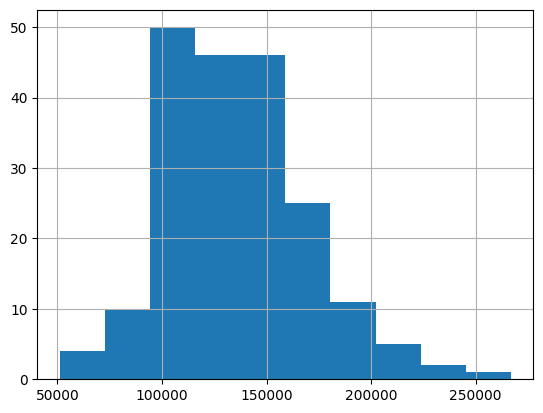

In [25]:
# check the dist of total travel distance, this should mirror a normal dist
# since we have set the stay proba in the settings to truncated norm curve
scoring_base.total_travel_distance.hist();

Clearly, the more transaction (hops) that you have, the higher is the travelled distance. 

In [97]:
def fetch_total_travel_distance(traj):
    coords = traj.coords.tolist()
    od_pairs = list(zip(coords, coords[1:]))
    dts = traj.transaction_dt.tolist()
    hrs = traj.transaction_hr.tolist()
    cels = traj.cel_uid.tolist()
    hr_pairs = list(zip(hrs, hrs[1:]))
    travel_distances = list(map(lambda p: calc_haversine_distance(*p), od_pairs))
    dt_df = pd.DataFrame(list(zip(dts, dts[1:])), columns=["orig_dt", "dest_dt"])
    hr_df = pd.DataFrame(list(zip(hrs, hrs[1:])), columns=["orig_hr", "dest_hr"])
    cel_df = pd.DataFrame(list(zip(cels, cels[1:])), columns=["orig_cel", "dest_cel"])
    data = pd.concat([dt_df, hr_df, cel_df], axis=1)
    data["travel_distance"] = travel_distances
    return data.loc[data.travel_distance>0].reset_index(drop=True)

In [92]:
metric = "total_travel_distance"
sample_traj_low, sample_traj_mid, sample_traj_high = fetch_sample_trajs(scoring_base, metric, date, window, fake_transactions, fake_cellsites)

In [218]:
def viz_total_travel_distance(sample_traj_low, sample_traj_mid, sample_traj_high):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    sample_low = fetch_total_travel_distance(sample_traj_low)
    sample_mid = fetch_total_travel_distance(sample_traj_mid)
    sample_high = fetch_total_travel_distance(sample_traj_high)
    sample_low["orig_dt"] = pd.to_datetime(sample_low["orig_dt"])
    sample_mid["orig_dt"] = pd.to_datetime(sample_mid["orig_dt"])
    sample_high["orig_dt"] = pd.to_datetime(sample_high["orig_dt"])
    sample_low.groupby("orig_dt")["travel_distance"].sum().plot(ax=ax1, color="red", kind="line")
    sample_mid.groupby("orig_dt")["travel_distance"].sum().plot(ax=ax1, color="blue", kind="line")
    sample_high.groupby("orig_dt")["travel_distance"].sum().plot(ax=ax1, color="green", kind="line")
    sample_low.groupby("orig_dt")["travel_distance"].sum().plot(ax=ax2, color="red", kind="density")
    sample_mid.groupby("orig_dt")["travel_distance"].sum().plot(ax=ax2, color="blue", kind="density")
    sample_high.groupby("orig_dt")["travel_distance"].sum().plot(ax=ax2, color="green", kind="density")
    ax1.set_ylabel("travel distance (in KM)")
    ax2.set_ylabel("density")
    ax1.set_xlabel("")
    ax2.set_xlabel("travel distance (in KM)")
    ax1.legend(["low", "mid", "high"], frameon=False)
    ax2.legend(["low", "mid", "high"], frameon=False)
    plt.tight_layout()
    plt.close();
    return fig

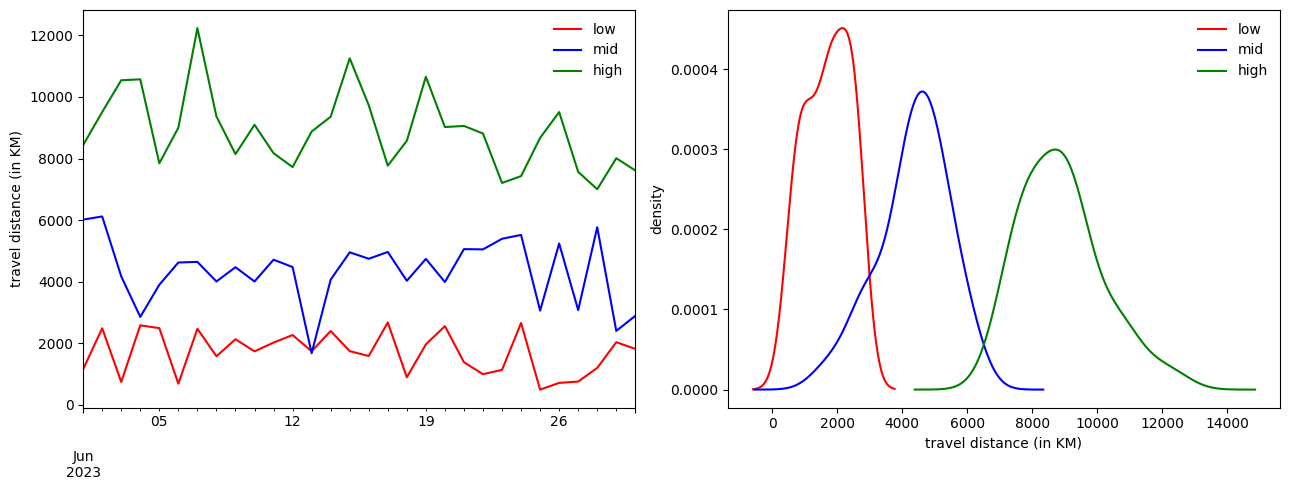

In [219]:
viz_total_travel_distance(sample_traj_low, sample_traj_mid, sample_traj_high)

TODO: add viz transaction count per day vs total distance travelled

Based on the time series and distribution of the **total travel distance** alone, we can already get a rough picture for the assignment of the  HIGH, MID, and LOW mobility groups. But this does not paint the whole picture. Let's try to visualize the actual movement of the subs using their monthly route (you should get a graph-like visualization) to see why.

In [230]:
def visualize_route(traj):
    coords = traj.coords.tolist()
    od_pairs = list(zip(coords, coords[1:]))
    routes = []
    for od_pair in od_pairs:
        routes.append(
            shapely.geometry.LineString(
                map(shapely.wkt.loads, od_pair)
            )
        )
    fig, ax = plt.subplots(1, figsize=(7, 5))
    gpd.GeoSeries(traj["coords"].apply(shapely.wkt.loads)).plot(ax=ax, color="blue", markersize=60, zorder=2);
    # gpd.GeoSeries(traj.head(1)["coords"].apply(shapely.wkt.loads)).plot(ax=ax, color="green", markersize=120, zorder=3);
    # gpd.GeoSeries(traj.tail(1)["coords"].apply(shapely.wkt.loads)).plot(ax=ax, color="red", markersize=120, zorder=3);
    gpd.GeoSeries(routes).plot(ax=ax, color="grey", linewidth=3, zorder=1, alpha=0.6)
    ax.ticklabel_format(useOffset=False)
    # ax.legend(["_", "orig", "dest"])
    plt.tight_layout()
    plt.axis("off")
    plt.close()
    return fig

this sub have a LOW total travel distance.


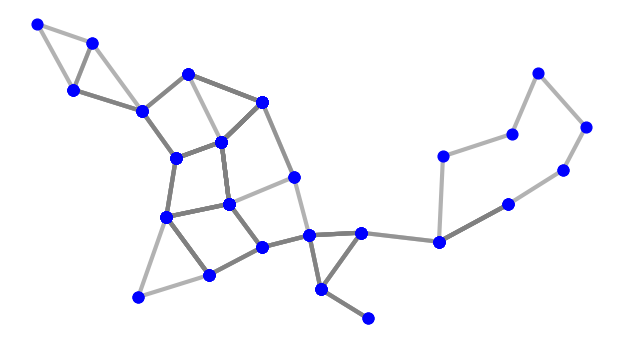

In [231]:
print(f"this sub have a LOW total travel distance.")
display(visualize_route(sample_traj_low))

this sub have a MID total travel distance.


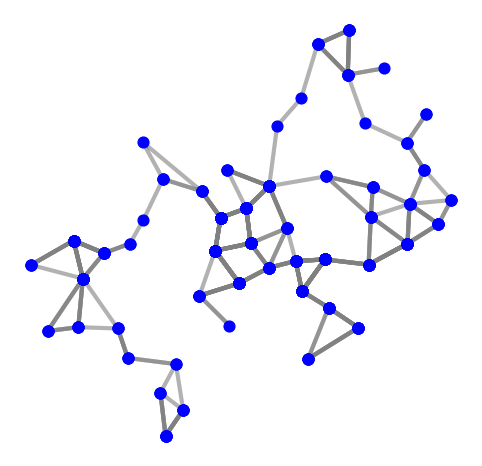

In [232]:
print(f"this sub have a MID total travel distance.")
display(visualize_route(sample_traj_mid))

this sub have a HIGH total travel distance.


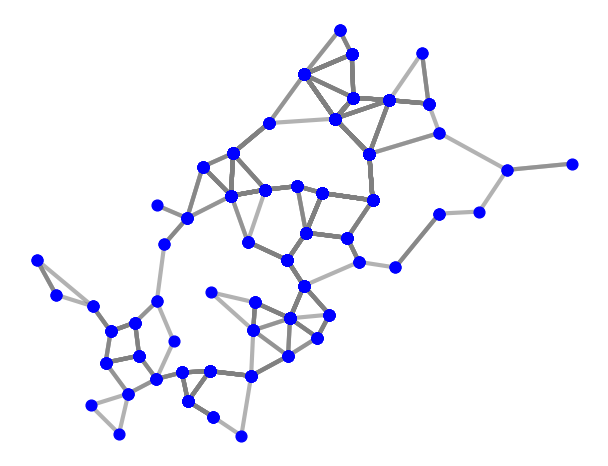

In [233]:
print(f"this sub have a HIGH total travel distance.")
display(visualize_route(sample_traj_high))

These graphs show that the total travel distance alone, cannot be used to approximate mobilty.

## 2: Radius of Gyration

In mobility analysis, the radius of gyration indicates the characteristic distance travelled by the agent (in our case, the telco mobile subscriber). This is computed using the given formula below:

$RoG$ = $\sqrt{\frac{1}{n} \sum \limits_{i=1}^{n} {dist(CoM,coord_i)^2}}$

$CoM$ = $\frac{1}{n} \sum \limits_{i=1}^{n} (lat_i, lng_i)$

Where: <br>
RoG is Radius of Gyration <br>
CoM is Center of Mass

Check radius of gyration (in meters) for a sample sub 

In [87]:
sub = fake_subscribers.sample(1).sub_uid.item()
traj = get_sub_traj(sub, date, window, fake_transactions, fake_cellsites)
traj.head()

,txn_uid,sub_uid,cel_uid,transaction_dt,transaction_hr,coords
0,glo-txn-39481,glo-sub-050,glo-cel-110,2023-06-01,5,POINT (121.0970233 14.5342057)
1,glo-txn-39482,glo-sub-050,glo-cel-111,2023-06-01,7,POINT (121.104064 14.5348903)
2,glo-txn-39483,glo-sub-050,glo-cel-110,2023-06-01,8,POINT (121.0970233 14.5342057)
3,glo-txn-39484,glo-sub-050,glo-cel-111,2023-06-01,9,POINT (121.104064 14.5348903)
4,glo-txn-39485,glo-sub-050,glo-cel-110,2023-06-01,10,POINT (121.0970233 14.5342057)


In [88]:
coords = traj.coords.tolist()

In [89]:
mean_lat = np.mean([shapely.wkt.loads(coord).y for coord in coords])
mean_lng = np.mean([shapely.wkt.loads(coord).x for coord in coords])
com = shapely.geometry.Point(mean_lng, mean_lat).wkt

In [90]:
print(mean_lat, mean_lng, com)

14.517850905714287 121.063812682 POINT (121.063812682 14.517850905714287)


In [91]:
# compute for the distances from center of mass to each of the individual points
pt_pairs = list(zip(coords, [com]*len(coords))) # points-to-centerofmass
radius_of_gyration = np.sqrt(
    reduce(
        lambda a, b: a + b,
        list(map(lambda p: calc_haversine_distance(*p)**2, pt_pairs))
    ) / len(coords)
)

In [92]:
radius_of_gyration

1401.6161206795764

Apply `calc_radius_of_gyration` to the scoring base

In [93]:
def calc_radius_of_gyration(traj):
    
    coords = traj.coords.tolist()
    
    # compute for the center of mass
    mean_lat = np.mean([shapely.wkt.loads(coord).y for coord in coords])
    mean_lng = np.mean([shapely.wkt.loads(coord).x for coord in coords])
    com = shapely.geometry.Point(mean_lng, mean_lat).wkt
    
    # compute for the distances from CoM to individual points
    pt_pairs = list(zip(coords, [com]*len(coords)))
    radius_of_gyration = np.sqrt(
        reduce(
            lambda a, b: a + b,
            list(map(lambda p: calc_haversine_distance(*p)**2, pt_pairs))
        ) / len(coords)
    )
    return radius_of_gyration

In [94]:
radius_of_gyrations = []
for sub in scoring_base.sub_uid.tolist():
    traj = get_sub_traj(sub, date, window, fake_transactions, fake_cellsites)
    radius_of_gyration = calc_radius_of_gyration(traj)
    radius_of_gyrations.append(radius_of_gyration)

scoring_base["radius_of_gyration"] = radius_of_gyrations

In [95]:
scoring_base.sample(5)

,sub_uid,gender,age,name,chi_indicator,ewallet_user_indicator,total_travel_distance,radius_of_gyration
46,glo-sub-150,female,44,Anna Wilson,False,Y,110414.409321,918.347203
186,glo-sub-079,male,57,Adrian Lopez,False,Y,187977.013357,806.840483
82,glo-sub-012,male,52,Russell Wood,False,N,123681.816641,2220.815435
127,glo-sub-151,female,49,Julie Johnson,False,Y,145577.396570,1594.642176
40,glo-sub-165,female,35,Sandra Miller,False,N,107085.731073,2189.927615


Let's visualize the result to better understand the concept

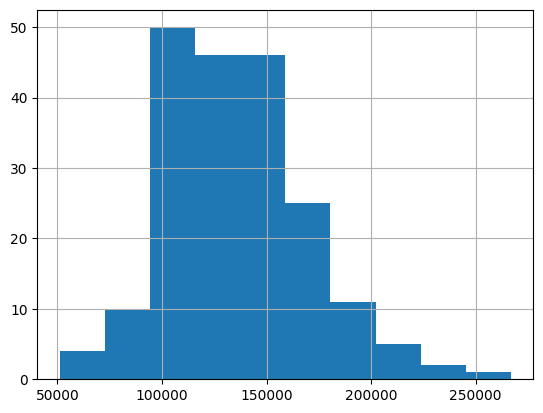

In [25]:
scoring_base.radius_of_gyration.hist();

In [26]:
scoring_base.sort_values(by="radius_of_gyration", ascending=True, inplace=True)
scoring_base.reset_index(drop=True, inplace=True)

In [27]:
sample_sub_low = scoring_base.loc[0, "sub_uid"]
sample_sub_mid = scoring_base.loc[len(scoring_base)//2, "sub_uid"]
sample_sub_high = scoring_base.loc[len(scoring_base)-1, "sub_uid"]

In [28]:
sample_traj_low = get_sub_traj(sample_sub_low, date, window, fake_transactions, fake_cellsites)
sample_traj_mid = get_sub_traj(sample_sub_mid, date, window, fake_transactions, fake_cellsites)
sample_traj_high = get_sub_traj(sample_sub_high, date, window, fake_transactions, fake_cellsites)

In [83]:
def visualize_route(traj):
    return 1

STOPPED HERE

## 3: Activity Entropy

if stay_proba is low, likely to have:

- LOWER total_travel_distance <br>
- LOWER radius_of_gyration <br>
- LOWER activity_entropy

Check activity entropy for a sample sub trajectory

In [34]:
sub = fake_subscribers.sample(1).sub_uid.item()
traj = get_sub_traj(sub, date, window, fake_transactions, fake_cellsites)
traj.head()

,txn_uid,sub_uid,cel_uid,transaction_dt,transaction_hr,coords
0,glo-txn-58921,glo-sub-027,glo-cel-005,2023-06-01,6,POINT (121.0281256 14.5208775)
2,glo-txn-58922,glo-sub-027,glo-cel-006,2023-06-01,7,POINT (121.03083 14.5277572)
1,glo-txn-58923,glo-sub-027,glo-cel-005,2023-06-01,9,POINT (121.0281256 14.5208775)
3,glo-txn-58924,glo-sub-027,glo-cel-007,2023-06-01,10,POINT (121.0342338 14.5181996)
4,glo-txn-58925,glo-sub-027,glo-cel-009,2023-06-01,13,POINT (121.0347379 14.5119065)


In [35]:
loc_hrs = traj[["cel_uid", "transaction_hr"]].values.tolist()
od_loc_hrs = list(zip(loc_hrs, loc_hrs[1:]))

In [36]:
cels = list(set(traj.cel_uid.tolist()))

In [37]:
loc_hr_counter = dict(zip(cels, [0]*len(cels))) # THIS IS THE HASHMAP
for od_loc_hr in od_loc_hrs:
    orig = od_loc_hr[0]
    dest = od_loc_hr[1]
    cel = orig[0]
    if dest[1] > orig[1]:
        time_elapsed = dest[1] - orig[1]
    elif dest[1] < orig[1]:
        # next time elapsed jumps to another day
        time_elapsed = 24 - abs(dest[1] - orig[1])
    loc_hr_counter[cel] = loc_hr_counter[cel] + time_elapsed #  # I UPDATED THE HASHMAP

In [38]:
loc_hr_counter

{'glo-cel-074': 8,
 'glo-cel-012': 2,
 'glo-cel-088': 2,
 'glo-cel-089': 39,
 'glo-cel-087': 10,
 'glo-cel-039': 7,
 'glo-cel-070': 29,
 'glo-cel-097': 5,
 'glo-cel-008': 3,
 'glo-cel-090': 2,
 'glo-cel-082': 3,
 'glo-cel-080': 14,
 'glo-cel-086': 25,
 'glo-cel-103': 7,
 'glo-cel-006': 2,
 'glo-cel-043': 13,
 'glo-cel-083': 26,
 'glo-cel-071': 12,
 'glo-cel-093': 5,
 'glo-cel-011': 5,
 'glo-cel-078': 14,
 'glo-cel-091': 10,
 'glo-cel-084': 75,
 'glo-cel-094': 15,
 'glo-cel-079': 22,
 'glo-cel-010': 1,
 'glo-cel-049': 4,
 'glo-cel-014': 10,
 'glo-cel-007': 3,
 'glo-cel-036': 2,
 'glo-cel-064': 19,
 'glo-cel-092': 20,
 'glo-cel-077': 32,
 'glo-cel-018': 10,
 'glo-cel-085': 3,
 'glo-cel-032': 1,
 'glo-cel-057': 7,
 'glo-cel-066': 30,
 'glo-cel-095': 16,
 'glo-cel-005': 2,
 'glo-cel-076': 1,
 'glo-cel-046': 15,
 'glo-cel-009': 1,
 'glo-cel-101': 21,
 'glo-cel-051': 12,
 'glo-cel-073': 25,
 'glo-cel-056': 28,
 'glo-cel-040': 8,
 'glo-cel-013': 13,
 'glo-cel-096': 41,
 'glo-cel-061': 4,
 'gl

In [39]:
traj # sanity check

,txn_uid,sub_uid,cel_uid,transaction_dt,transaction_hr,coords
0,glo-txn-58921,glo-sub-027,glo-cel-005,2023-06-01,6,POINT (121.0281256 14.5208775)
2,glo-txn-58922,glo-sub-027,glo-cel-006,2023-06-01,7,POINT (121.03083 14.5277572)
1,glo-txn-58923,glo-sub-027,glo-cel-005,2023-06-01,9,POINT (121.0281256 14.5208775)
3,glo-txn-58924,glo-sub-027,glo-cel-007,2023-06-01,10,POINT (121.0342338 14.5181996)
4,glo-txn-58925,glo-sub-027,glo-cel-009,2023-06-01,13,POINT (121.0347379 14.5119065)
...,...,...,...,...,...,...
32,glo-txn-59195,glo-sub-027,glo-cel-039,2023-06-30,14,POINT (121.0536333 14.5133711)
275,glo-txn-59196,glo-sub-027,glo-cel-046,2023-06-30,16,POINT (121.0560984 14.5100246)
33,glo-txn-59197,glo-sub-027,glo-cel-039,2023-06-30,19,POINT (121.0536333 14.5133711)
276,glo-txn-59198,glo-sub-027,glo-cel-046,2023-06-30,20,POINT (121.0560984 14.5100246)


In [40]:
proba_per_site = [hr_spent/sum(loc_hr_counter.values()) for hr_spent in loc_hr_counter.values()]

In [41]:
np.sum(proba_per_site)

1.0000000000000002

In [42]:
activity_entropy = reduce(lambda a, b: a + b, map(lambda p: p*np.log10(1/p), proba_per_site))
print(activity_entropy)

# TODO: add logbase2
# try float dtype

1.5510208886967467


Apply `calc_activity_entropy` to the scoring base

In [43]:
def calc_activity_entropy(traj):
    
    try:
    
        loc_hrs = traj[["cel_uid", "transaction_hr"]].values.tolist()
        od_loc_hrs = list(zip(loc_hrs, loc_hrs[1:]))    
        cels = list(set(traj.cel_uid.tolist()))

        loc_hr_counter = dict(zip(cels, [0]*len(cels)))
        for od_loc_hr in od_loc_hrs:
            orig = od_loc_hr[0]
            dest = od_loc_hr[1]
            cel = orig[0]
            if dest[1] > orig[1]:
                time_elapsed = dest[1] - orig[1]
            elif dest[1] < orig[1]:
                # next time elapsed jumps to another day
                time_elapsed = 24 - abs(dest[1] - orig[1])
            loc_hr_counter[cel] = loc_hr_counter[cel] + time_elapsed

        # time spent on a single site vs time spent on all sites
        proba_per_site = [hr_spent/sum(loc_hr_counter.values()) for hr_spent in loc_hr_counter.values()]

        # sum(p * log(1/p)) where p is the proba for a single site
        activity_entropy = reduce(lambda a, b: a + b, map(lambda p: p*np.log10(1/p), proba_per_site))
    
        return activity_entropy
    
    except:
        
        return None

In [44]:
activity_entropys = []
for sub in scoring_base.sub_uid.tolist():
    traj = get_sub_traj(sub, date, window, fake_transactions, fake_cellsites)
    activity_entropy = calc_activity_entropy(traj)
    activity_entropys.append(activity_entropy)

scoring_base["activity_entropy"] = activity_entropys

In [45]:
scoring_base.sample(5)

,sub_uid,gender,age,name,chi_indicator,ewallet_user_indicator,total_travel_distance,radius_of_gyration,activity_entropy
163,glo-sub-164,female,22,Gloria Trujillo,True,Y,115182.369226,1403.441567,1.510481
113,glo-sub-114,male,47,Derek Davis,True,Y,167734.591832,1493.636042,1.558330
128,glo-sub-129,female,51,Kimberly Reed,False,N,110645.495795,578.135988,0.949096
14,glo-sub-015,male,50,Michael Hamilton,True,N,121623.648025,1706.857045,1.541325
18,glo-sub-019,female,53,Rachael Meyers,False,Y,154121.590363,875.080916,1.180302


## 4. Visualization

if stay_proba is low, likely to have:

- LOWER total_travel_distance <br>
- LOWER radius_of_gyration <br>
- LOWER activity_entropy

In [26]:
scoring_base.sort_values(by="total_travel_distance", ascending=True, inplace=True)
scoring_base.reset_index(drop=True, inplace=True)

In [27]:
sample_sub_low = scoring_base.loc[0, "sub_uid"]
sample_sub_mid = scoring_base.loc[len(scoring_base)//2, "sub_uid"]
sample_sub_high = scoring_base.loc[len(scoring_base)-1, "sub_uid"]

In [28]:
sample_traj_low = get_sub_traj(sample_sub_low, date, window, fake_transactions, fake_cellsites)
sample_traj_mid = get_sub_traj(sample_sub_mid, date, window, fake_transactions, fake_cellsites)
sample_traj_high = get_sub_traj(sample_sub_high, date, window, fake_transactions, fake_cellsites)

In [83]:
def visualize_route(traj):
    coords = traj.coords.tolist()
    od_pairs = list(zip(coords, coords[1:]))
    routes = []
    for od_pair in od_pairs:
        routes.append(
            shapely.geometry.LineString(
                map(shapely.wkt.loads, od_pair)
            )
        )
    fig, ax = plt.subplots(1, figsize=(7, 5))
    gpd.GeoSeries(traj["coords"].apply(shapely.wkt.loads)).plot(ax=ax, color="blue", markersize=60, zorder=2);
    gpd.GeoSeries(traj.head(1)["coords"].apply(shapely.wkt.loads)).plot(ax=ax, color="green", markersize=120, zorder=3);
    gpd.GeoSeries(traj.tail(1)["coords"].apply(shapely.wkt.loads)).plot(ax=ax, color="red", markersize=120, zorder=3);
    gpd.GeoSeries(routes).plot(ax=ax, color="grey", linewidth=3, zorder=1, alpha=0.6)
    ax.ticklabel_format(useOffset=False)
    ax.legend(["_", "orig", "dest"])
    plt.tight_layout()
    plt.axis("off")
    plt.close()
    return fig

this sub travelled 51.18 KM in a month, LIKELY TO HAVE LOW MOBILITY


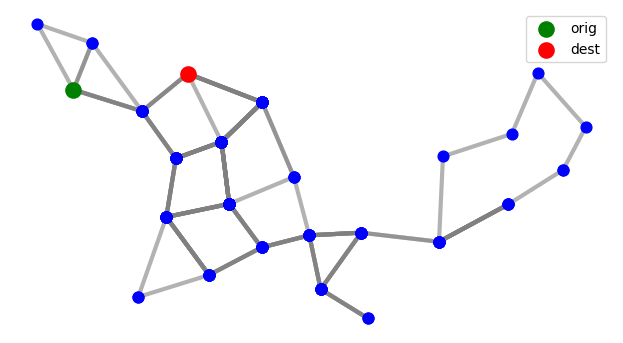

In [84]:
travel_distance_in_km = round(scoring_base.loc[scoring_base.sub_uid==sample_sub_low, "total_travel_distance"].item() / 1_000, 2)
print(f"this sub travelled {travel_distance_in_km} KM in a {window}, LIKELY TO HAVE LOW MOBILITY")
display(visualize_route(sample_traj_low))

this sub travelled 130.69 KM in a month, LIKELY TO HAVE MID MOBILITY


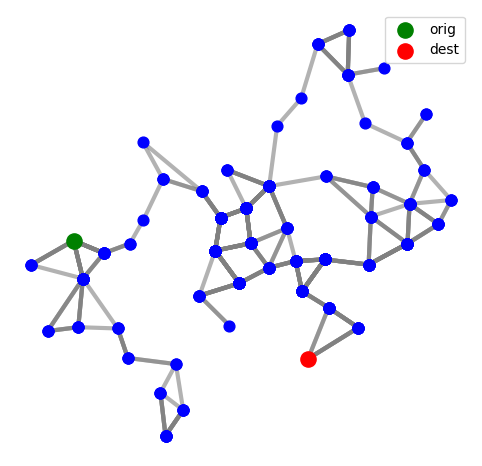

In [85]:
travel_distance_in_km = round(scoring_base.loc[scoring_base.sub_uid==sample_sub_mid, "total_travel_distance"].item() / 1_000, 2)
print(f"this sub travelled {travel_distance_in_km} KM in a {window}, LIKELY TO HAVE MID MOBILITY")
display(visualize_route(sample_traj_mid))

this sub travelled 266.82 KM in a month, LIKELY TO HAVE HIGH MOBILITY


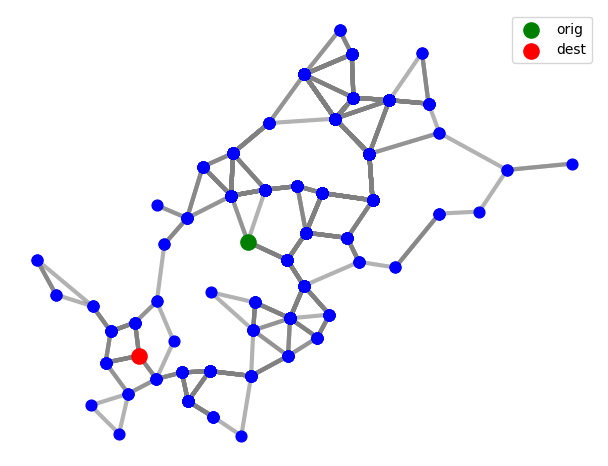

In [86]:
travel_distance_in_km = round(scoring_base.loc[scoring_base.sub_uid==sample_sub_high, "total_travel_distance"].item() / 1_000, 2)
print(f"this sub travelled {travel_distance_in_km} KM in a {window}, LIKELY TO HAVE HIGH MOBILITY")
display(visualize_route(sample_traj_high))

TODO:
1. Make your own Mobility Index: HIGH-MID-LOW

## RESULTS QA

In [46]:
scoring_base.total_travel_distance.describe().iloc[1:]

mean    135365.978688
std      34060.304293
min      51182.047777
25%     111875.270825
50%     130679.843486
75%     154596.447748
max     266816.677803
Name: total_travel_distance, dtype: float64

In [47]:
scoring_base.radius_of_gyration.describe().iloc[1:]

mean    1488.527682
std      454.251797
min      578.135988
25%     1192.525488
50%     1466.560640
75%     1760.898864
max     3112.181536
Name: radius_of_gyration, dtype: float64

In [48]:
scoring_base.activity_entropy.describe().iloc[1:]

mean    1.439375
std     0.150639
min     0.919816
25%     1.358496
50%     1.467371
75%     1.541902
max     1.741984
Name: activity_entropy, dtype: float64

In [49]:
sub = fake_subscribers.sample(1).sub_uid.item()
traj = get_sub_traj(sub, date, window, fake_transactions, fake_cellsites)

In [50]:
traj.head()

,txn_uid,sub_uid,cel_uid,transaction_dt,transaction_hr,coords
0,glo-txn-52770,glo-sub-075,glo-cel-018,2023-06-01,3,POINT (121.0448854 14.5140967)
1,glo-txn-52771,glo-sub-075,glo-cel-032,2023-06-01,4,POINT (121.0499415 14.5159856)
2,glo-txn-52772,glo-sub-075,glo-cel-022,2023-06-01,5,POINT (121.0462595 14.5165155)
3,glo-txn-52773,glo-sub-075,glo-cel-027,2023-06-01,7,POINT (121.0482758 14.5207167)
8,glo-txn-52774,glo-sub-075,glo-cel-036,2023-06-01,8,POINT (121.052231 14.519476)


In [51]:
calc_activity_entropy(traj)

1.5298917317491276

In [52]:
calc_radius_of_gyration(traj)

1678.0288201073324

In [53]:
calc_total_travel_distance(traj)

184442.6669373246

## PENDING ITEMS

[X] Redo the fake data simulation, make stay proba variable instead of fixed <br>
[] Add visuals on total travel distance, radius of gyration, activity entropy <br>
[] Finish lecture part 1, grammar of spatial data science

## ARCHIVE

In [14]:
def get_route_fig(r):
    fig, ax = plt.subplots(1, 1)
    gpd.GeoSeries(r).plot(ax=ax, linewidth=5, zorder=1)
    orig = shapely.geometry.Point([r.xy[0][0], r.xy[1][0]])
    dest = shapely.geometry.Point([r.xy[0][-1], r.xy[1][-1]])
    gpd.GeoSeries(orig).plot(ax=ax, color="red", markersize=250, zorder=2, alpha=0.8)
    gpd.GeoSeries(dest).plot(ax=ax, color="green", markersize=250, zorder=2, alpha=0.8)
    plt.axis("off")
    ax.ticklabel_format(useOffset=False)
    plt.close()
    return fig

import os
import shapely
import geopandas as gpd
import matplotlib.pyplot as plt
from PIL import Image
import shutil

In [15]:
# day in a life of a sub
d = fake_transactions.copy()
sample_sub = d.sample(1).sub_id.item()
d = d.loc[d.sub_id==sample_sub]
days = d.transaction_dt.unique().tolist()
route_figs = []
for sample_day in days:
    sites = fake_transactions\
        .loc[fake_transactions.sub_id==sample_sub]\
        .loc[fake_transactions.transaction_dt==sample_day]\
        .cel_id.tolist()
    points = list(map(lambda z: convert_cel_to_point(z, fake_cellsites), sites))
    r = shapely.geometry.LineString(points)
    route_figs.append(get_route_fig(r))
os.mkdir("../sample/")
for idx, fig in enumerate(route_figs):
    fname = "../sample/{}_tmp.jpg".format(idx+1)
    fig.savefig(fname)
imgs = load_images("../sample")
plot_images(imgs)
shutil.rmtree("../sample")

AttributeError: 'DataFrame' object has no attribute 'uid'